In [1]:
 # To mount Google Drive
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/ocsvm_results.csv')
print("Original Size of dataset: {}".format(len(df)))

profiles_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_profiles.csv')
print("Original number of users: {}".format(len(profiles_df)))

products_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_product_info.csv')
print("Original number of products: {}".format(len(products_df)))

filtered_df = df[df['fake_reviews'] == 1]
suspicious_users = list(set(filtered_df['acc_num']))
print("Number of suspicious users: {}".format(len(suspicious_users)))

filtered_df = df[df['acc_num'].isin(suspicious_users)]
print("Size of dataset with fake reviews: {}".format(len(filtered_df)))

Original Size of dataset: 77268
Original number of users: 65930
Original number of products: 102
Number of suspicious users: 12298
Size of dataset with fake reviews: 16114


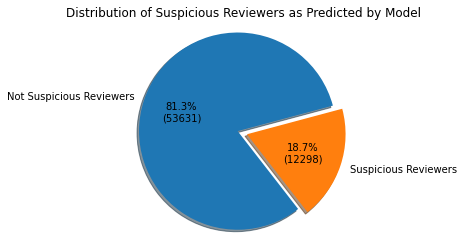

In [3]:
import matplotlib.pyplot as plt

# # Creating plot 
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

non_suspicious_users = len(profiles_df) -  len(suspicious_users)

my_explode = (0, 0.1)
plt.pie([non_suspicious_users, len(suspicious_users)],labels=['Not Suspicious Reviewers','Suspicious Reviewers'],autopct=lambda pct: func(pct, [non_suspicious_users, len(suspicious_users)]),startangle=15, shadow = True, explode=my_explode)
plt.title("Distribution of Suspicious Reviewers as Predicted by Model")
plt.axis('equal')
plt.show()

In [51]:
!pip install fuzzywuzzy
import networkx as nx
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

try:
    network_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv')
except:
    !pip install --upgrade rgmining-fraud-eagle

    import fraud_eagle as feagle

    # Create a graph with a parameter `epsilon`.
    epsilon = 0.1
    graph = feagle.ReviewGraph(epsilon)

    reviewers = {}
    for reviewer in set(filtered_df['acc_num']):
        reviewers[reviewer] = graph.new_reviewer(reviewer)

    products = {}
    for product in set(filtered_df['asin']):
        products[product] = graph.new_product(product)

    for reviewer, product, rating in zip(filtered_df['acc_num'], filtered_df['asin'],filtered_df['cleaned_reviews_ratings']):
        graph.add_review(reviewers[reviewer], products[product], rating)

    max_iteration = 10000
    for i in range(max_iteration):

        # Run one iteration.
        diff = graph.update()
        print("Iteration {}...Difference={}".format(i + 1, diff))

        if diff < 10**-5: # Set 10^-5 as an acceptable small number.
            print("Difference is significantly small...Stopping Iteration...")
            break
    top_users = [r.name for r in graph.reviewers if r.anomalous_score >= 0.9]
    print(top_users)
    print(len(top_users))

    all_unique_users = list(filtered_df['acc_num'])
    build_network = {"user1":[],"user2":[],"weights":[]}
    for i,user1 in enumerate(top_users):
        print("Current Iteration: {}/{}".format(i+1,len(top_users)))
        user1_text = list(filtered_df[filtered_df['acc_num'] == user1]['decoded_comment'])
        for user2 in top_users[1:]:
            if user1 != user2 :
                user2_text = list(filtered_df[filtered_df['acc_num'] == user2]['cleaned_reviews_text'])
                similar_reviews = 0
                for text1 in user1_text:
                    extract_list = process.extract(text1, user2_text)
                    for item in extract_list:
                      if item[1] >= 85:
                        similar_reviews += 1
                if similar_reviews > 0:
                    build_network['user1'].append(user1)
                    build_network['user2'].append(user2)
                    build_network['weights'].append(similar_reviews)
        print("Current Dataset size: {}...\n".format(len(build_network['user1'])))

    network_df = pd.DataFrame.from_dict(build_network)
    user1_names = []
    user2_names = []
    for index, row in network_df.iterrows():
        user1_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user1'],'name'])[0])
        user2_name = str(list(profiles_df.loc[profiles_df['acc_num'] == row['user2'],'name'])[0])
        user1_names.append(user1_name)
        user2_names.append(user2_name)

    deleted_users = ['Amazon user', 'Amazon Customer']
    network_df['user1_name'] = user1_names
    network_df['user2_name'] = user2_names
    network_df = network_df[(~network_df['user1_name'].isin(deleted_users)) & (~network_df['user2_name'].isin(deleted_users))]
    print("New Length of Network Dataset after keeping interested nodes: {}".format(len(network_df)))
    display(network_df)

    interested_graph = build_graph(network_df)
    network_df.to_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv',index=False)
network_df = network_df[network_df['weights'] >= 10]
print("Length of Network Dataset: {}".format(len(network_df)))
display(network_df)


Length of Network Dataset: 170


,user1,user2,weights,user1_name,user2_name
64,AHZGQNY7E7QBFANXD6LQCIT5Y3LQ,AFMYDGF3WUNIPG5JPS44LOVGQZOQ,10,ALW,Andrea
71,AHZGQNY7E7QBFANXD6LQCIT5Y3LQ,AELD5XB7WAKU4T75C7K7A7BDCBQA,12,ALW,Sher
77,AHZGQNY7E7QBFANXD6LQCIT5Y3LQ,AEW7U7LUVQRPZQOAT4QYBL2RTTOA,12,ALW,Samie
112,AHZGQNY7E7QBFANXD6LQCIT5Y3LQ,AFB4ZPG5DEX6OLF4FJJP2O26RGYA,12,ALW,Jen
118,AHZGQNY7E7QBFANXD6LQCIT5Y3LQ,AEK5XNO2BPYCGSSH7WKEXCQZOPCQ,12,ALW,altinstar
...,...,...,...,...,...
12517,AHFCK4U2URKU3Q5A4257WVAM5RUQ,AFB4ZPG5DEX6OLF4FJJP2O26RGYA,12,MUSElover,Jen
12524,AHFCK4U2URKU3Q5A4257WVAM5RUQ,AEK5XNO2BPYCGSSH7WKEXCQZOPCQ,12,MUSElover,altinstar
12614,AGR4LJDW7OQ4GBYOOFKEAC66NEYQ,AHMG3ALUBE3FEBHODTBHP5J24YDA,12,K.P,Colorgirl
12658,AGR4LJDW7OQ4GBYOOFKEAC66NEYQ,AFB4ZPG5DEX6OLF4FJJP2O26RGYA,12,K.P,Jen


In [52]:
import plotly.graph_objects as go
from networkx.algorithms.centrality import *
import networkx as nx
import pandas as pd

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

def visualize_graph(graph,network_df):
    reviewers_name = list(network_df['user1_name']) + list(network_df['user2_name'])
    reviewers_acc_name =  list(network_df['user1']) + list(network_df['user2'])
    reviewer_mapping = {}
    pos = nx.spring_layout(graph,k=0.3*1/np.sqrt(len(graph.nodes())), iterations=3000,scale=50)

    edge_x = []

    edge_y = []
    for edge in graph.edges():
        from_edge = edge[0]
        to_edge = edge[1]
        x0 = pos[from_edge][0]
        y0 = pos[from_edge][1]
        x1 = pos[to_edge][0]
        y1 = pos[to_edge][1]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x = pos[node][0]
        y = pos[node][1]
        node_x.append(x)
        node_y.append(y)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Portland',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Betweeness Centrality',
                xanchor='left',
                titleside='right'
            ),
        line_width=2))

    

    for reviewer_acc_name, reviewer_name in zip(reviewers_acc_name,reviewers_name):
        if reviewer_acc_name not in reviewer_mapping:
            reviewer_mapping[reviewer_acc_name] = reviewer_name
    node_adjacencies = []
    betweeness = betweenness_centrality(interested_graph)
    closeness = closeness_centrality(interested_graph)
    color = []
    node_text = []
    for node, adjacencies in enumerate(graph.adjacency()):
        temp_graph = graph.to_undirected()
        neighbours = list(temp_graph.neighbors(adjacencies[0]))
        neighbours = [neighbour for neighbour in neighbours if neighbour != adjacencies[0]]
        number_neighbours = len(neighbours)
        # node_adjacencies.append(number_neighbours)
        node_adjacencies.append(closeness[adjacencies[0]])
        color.append(betweeness[adjacencies[0]])
        node_text.append("{} has {} connections. Reviewer's Account Number is {}".format(reviewer_mapping[adjacencies[0]],number_neighbours,adjacencies[0]))

    node_trace.marker.color = color
    max_adjacencies = max(node_adjacencies)
    node_adjacencies = [max(8,15*(node_adjacency/max_adjacencies)) for node_adjacency in node_adjacencies]
    node_trace.marker.size = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                # margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                title="Network Containing Top Suspicious Reviewers" 
                )
                )
    
    fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1), plot_bgcolor='rgb(255,255,255)')
    
    return fig

interested_graph = build_graph(network_df)
fig = visualize_graph(interested_graph,network_df)
fig.show()